# Single Ended Spiral Inductor Modeling with PyAEDT
This example shows how to build a simple single-ended spiral inductor, setup ports, run simulation and generate the report with PyAEDT
## Setup Dimension of Spiral Inductor
- rin (um): Inner radius
- width (um): Line width
- spacing (um): Spacing betwee lines
- thickness (um): Spiral metal thickness
- Np: Sides of spiral
- Nr: Rounds of spiral
- gap (um): Gap betwee metal_1 and metal_2
- Tsun (um): Thickness of substrate

In [1]:
rin = 10
width = 2
spacing = 2
thickness = 1
Np = 8
Nr = 6
gap = 3
Tsub = 6

## Define Spiral Polyline Function

In [2]:
import os
import matplotlib.pyplot as plt
from math import pi, cos, sin, tan, sqrt

def spiral(rin=10, pitch=2, Np=8, Nr=10):
    dtheta = 2 * pi / Np
    theta = pi / 2
    pts = [(rin, 0), (rin, rin * tan(dtheta / 2))]
    rin = rin * tan(dtheta / 2) * 2

    x = rin
    r = rin
    for i in range(Np):
        r += 1
        theta += dtheta
        x = x + r * cos(theta)
        dr = pitch / (x - rin)

    for i in range(Nr * Np - int(Np / 2) - 1):
        rin += dr
        theta += dtheta
        x0, y0 = pts[-1]
        x1, y1 = x0 + rin * cos(theta), y0 + rin * sin(theta)
        pts.append((x1, y1))

    pts.append((x1, 0))
    return pts

## Build Geometry

In [3]:
from pyaedt import Desktop, Hfss, constants

hfss = Hfss(specified_version="2021.2", non_graphical=True)
hfss.modeler.model_units = "um"
p = hfss.modeler.primitives

def create_line(pts):
    p.create_polyline(pts,
                      xsection_type='Rectangle',
                      xsection_width=width,
                      xsection_height=thickness, 
                      matname='copper', 
                      name='spiral')

pts = [(x0, y0, 0) for (x0, y0) in spiral(rin, (width + spacing), Np, Nr)]
create_line(pts)

x0, y0, z0 = pts[0]
x1, y1, z1 = pts[-1]

create_line([(x0 - width / 2, y0, -gap), (abs(x1) + 5, y0, -gap)])
p.create_rectangle(constants.PLANE.YZ,
                   (abs(x1) + 5, y0 - width / 2, -gap - thickness / 2),
                   (width, -Tsub + gap),
                   name='port1')

create_line([(x1 + width / 2, y1, 0), (x1 - 5, y1, 0)])

p.create_rectangle(constants.PLANE.YZ,
                   (x1 - 5, y1 - width / 2, -thickness / 2),
                   (width, -Tsub),
                   name='port2')

p.create_box((x0 - width / 2, y0 - width / 2, -gap - thickness / 2),
             (width, width, gap + thickness),
             matname='copper', name='via')

p.create_box([x1 - 20, x1 - 20, -Tsub - thickness / 2],
             [-2 * x1 + 40, -2 * x1 + 40, Tsub],
             matname='silicon')

p.create_box([x1 - 20, x1 - 20, -Tsub - thickness / 2],
             [-2 * x1 + 40, -2 * x1 + 40, -0.1],
             matname='PEC')

box = p.create_box([x1 - 20, x1 - 20, -Tsub - thickness / 2 - 0.1],
                   [-2 * x1 + 40, -2 * x1 + 40, 100],
                   name='airbox',
                   matname='air')

hfss.assign_radiation_boundary_to_objects('airbox')
hfss.change_material_override()

Launching PyAEDT outside Electronics Desktop with CPython and Pythonnet
Launching AEDT installation C:\Program Files\AnsysEM\AnsysEM21.2\Win64
pyaedt info: Launching AEDT with module Pythonnet.
pyaedt info: Ansoft.ElectronicsDesktop.2021.2 Started with process ID 21740.
pyaedt info: Logger Started on D:\temp\pyaedt20211222_133101.log
pyaedt info: pyaedt v0.4.17
pyaedt info: Python version 3.8.7 (tags/v3.8.7:6503f05, Dec 21 2020, 17:59:51) [MSC v.1928 64 bit (AMD64)]
pyaedt info: Project Project105 has been created.
pyaedt info: No design is present. Inserting a new design.
pyaedt info: Design Loaded
pyaedt info: Successfully loaded project materials !
pyaedt info: Materials Loaded
pyaedt info: Boundary Radiation Rad__5YS6L0 has been correctly created.
pyaedt info: Enabling Material Override


True

## Add Ports, Setup and Run Simulation

In [4]:
hfss.create_lumped_port_to_sheet(sheet_name='port1', axisdir=constants.AXIS.Z)
hfss.create_lumped_port_to_sheet(sheet_name='port2', axisdir=constants.AXIS.Z)

setup1 = hfss.create_setup(setupname='setup1')
setup1.props['Frequency'] = '10GHz'
hfss.create_frequency_sweep('setup1', 'GHz', 1e-3, 50)
setup1.update()

hfss.save_project()

hfss.analyze_all()

pyaedt info: Boundary LumpedPort Port_VHI0DV has been correctly created.
pyaedt info: Boundary LumpedPort Port_0313BG has been correctly created.
pyaedt info: Linear count sweep Sweep_6B0PRG has been correctly created
pyaedt info: Saving Project105 Project


True

## Extract S Parameter and Plot L and Q

pyaedt info: Solution Data Correctly Loaded.
pyaedt info: Solution Data Correctly Loaded.
pyaedt info: Saving Project105 Project


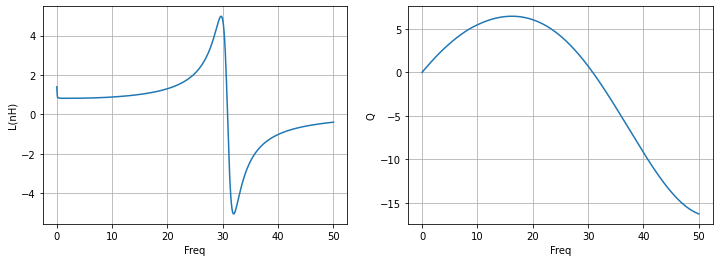

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))


L_formula = '1e9*im(1/Y(1,1))/(2*pi*freq)'
f, m = [], []
x = hfss.post.get_report_data(L_formula)

for freq in x.solutions_data_real[L_formula]:
    mag = x.solutions_data_real[L_formula][freq]
    f.append(freq[0])
    m.append(mag)

ax1.grid()
ax1.set_xlabel('Freq')
ax1.set_ylabel('L(nH)')
ax1.plot(f, m)

L_formula = 'im(Y(1,1))/re(Y(1,1))'
f, m = [], []
x = hfss.post.get_report_data(L_formula)
hfss.save_project()
for freq in x.solutions_data_real[L_formula]:
    mag = x.solutions_data_real[L_formula][freq]
    f.append(freq[0])
    m.append(-mag)

ax2.grid()
ax2.set_xlabel('Freq')
ax2.set_ylabel('Q')
ax2.plot(f, m)

## Plot 3D Field

In [6]:
surf = []
for i in ['spiral', 'spiral_1', 'spiral_2', 'via']:
    surf += hfss.modeler.get_object_faces(i)
intrinsic = {"Freq": "10GHz", "Phase": "0deg"}
plot1 = hfss.post.create_fieldplot_surface(surf, "ComplexMag_E", "setup1 : LastAdaptive", intrinsic)
path = os.path.join(hfss.project_path, hfss.project_name + ".aedtresults")
print(path)
hfss.post.plot_field_from_fieldplot(
    plot1.name,
    project_path=path,
    meshplot=True,
    setup_name="setup1 : LastAdaptive",
    intrinsic_dict=intrinsic,
    imageformat="jpg",
    view="isometric",
    off_screen=True,
)

D:\temp\Project105.aedtresults
pyaedt info: PyVista plot generation took 0.0468745231628418 seconds.


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

Field Generation, export and plot time:  0.6702241897583008


['D:\\temp\\Project105.aedtresults\\ComplexMag_E_2WL6RU.jpg']

## Export Animation Gif of Mag_E

In [ ]:
phases = [str(i * 5) + "deg" for i in range(18)]
hfss.post.animate_fields_from_aedtplt_2(
    quantityname="Mag_E",
    object_list= ["Global:XY"],
    plottype="CutPlane",
    meshplot=False,
    setup_name="setup1 : LastAdaptive",
    intrinsic_dict={"Freq": "10GHz", "Phase": "0deg"},
    project_path=path,
    variation_variable="Phase",
    variation_list=phases,
    off_screen=False,
    export_gif=True,
)

D:\temp\Project105.aedtresults\Mag_E_3WTDKH0


ERROR:root:1: #version 150


## Close Desktop and Release License

In [ ]:
hfss.release_desktop()